K-平均聚类算法
===

# 1.图像识别
不需要预期输出的无监督学习

## 1.1.生成质心
- 对图像进行减色化处理，然后计算直方图，将其用作特征量；
- 对每张图像随机分配类别0或类别1
- 分别计算类别0和类别1的特征量的质心并存储

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

# Dicrease color
def dic_color(img):
    img //= 63
    img = img * 64 + 32
    return img


# Database
def get_DB():
    # get training image path
    train = glob("data/dataset/test_*")
    train.sort()

    # prepare database
    db = np.zeros((len(train), 13), dtype=np.int32)
    pdb = []

    # each train
    for i, path in enumerate(train):
        # read image
        img = dic_color(cv2.imread(path))
        # histogram
        for j in range(4):
            db[i, j] = len(np.where(img[..., 0] == (64 * j + 32))[0])
            db[i, j+4] = len(np.where(img[..., 1] == (64 * j + 32))[0])
            db[i, j+8] = len(np.where(img[..., 2] == (64 * j + 32))[0])

        # get class
        if 'akahara' in path:
            cls = 0
        elif 'madara' in path:
            cls = 1

        # store class label
        db[i, -1] = cls

        # add image path
        pdb.append(path)

    return db, pdb

# k-Means step1
def k_means_step1(db, pdb, Class=2):
    # copy database
    feats = db.copy()

    # initiate random seed
    np.random.seed(1)

    # assign random class 
    for i in range(len(feats)):
        if np.random.random() < 0.5:
            feats[i, -1] = 0
        else:
            feats[i, -1] = 1

    # prepare gravity
    gs = np.zeros((Class, 12), dtype=np.float32)
        
    # get gravity
    for i in range(Class):
        gs[i] = np.mean(feats[np.where(feats[..., -1] == i)[0], :12], axis=0)
    print("assigned label")
    print(feats)
    print("Grabity")
    print(gs)


db, pdb = get_DB()
k_means_step1(db, pdb)

assigned label
[[ 1493  7892  4900  2099  1828  9127  4534   895  1554  6750  5406  2674
      0]
 [  242 10338  3628  2176   587 12212  2247  1338   434 10822  4506   622
      1]
 [ 6421  5478   719  3766  5482  4294  2537  4071  5609  4823  2051  3901
      0]
 [ 3343  8134  4756   151  3787  7588  3935  1074  3595  8444  4069   276
      0]]
Grabity
[[ 3752.3333  7168.      3458.3333  2005.3334  3699.      7003.
   3668.6667  2013.3334  3586.      6672.3335  3842.      2283.6667]
 [  242.     10338.      3628.      2176.       587.     12212.
   2247.      1338.       434.     10822.      4506.       622.    ]]


## 1.2.聚类
- 对于每个图像，计算特征量与质心之间的距离(在此取欧氏距离)，并将图像指定为质心更接近的类别。
- 重复步骤直到没有数据的类别再改变为止。

k-平均聚类算法是一种完全按范围划分类别的方法。一条数据最后被划分到什么类别只有到最后才清楚。此外，必须预先知道类别的数量。需要注意的是，k-平均聚类算法最初分配的类别对最后的结果有很大的影响。并且，数据量小的情况下极有可能失败。也就是说，数据量越大最后得到的数据分布越准确。

In [5]:
def get_DB():
    # get training image path
    train = glob("data/dataset/train_*")
    train.sort()

    # prepare database
    db = np.zeros((len(train), 13), dtype=np.int32)
    pdb = []

    # each train
    for i, path in enumerate(train):
        # read image
        img = dic_color(cv2.imread(path))
        # histogram
        for j in range(4):
            db[i, j] = len(np.where(img[..., 0] == (64 * j + 32))[0])
            db[i, j+4] = len(np.where(img[..., 1] == (64 * j + 32))[0])
            db[i, j+8] = len(np.where(img[..., 2] == (64 * j + 32))[0])

        # get class
        if 'akahara' in path:
            cls = 0
        elif 'madara' in path:
            cls = 1

        # store class label
        db[i, -1] = cls

        # add image path
        pdb.append(path)

    return db, pdb

def k_means_step2(db, pdb, Class=2):
    # copy database
    feats = db.copy()

    # initiate random seed
    np.random.seed(1)

    # assign random class 
    for i in range(len(feats)):
        if np.random.random() < 0.5:
            feats[i, -1] = 0
        else:
            feats[i, -1] = 1

    while True:
        # prepare greavity
        gs = np.zeros((Class, 12), dtype=np.float32)
        change_count = 0

        # compute gravity
        for i in range(Class):
            gs[i] = np.mean(feats[np.where(feats[..., -1] == i)[0], :12], axis=0)

        # re-labeling
        for i in range(len(feats)):
            # get distance each nearest graviry
            dis = np.sqrt(np.sum(np.square(np.abs(gs - feats[i, :12])), axis=1))

            # get new label
            pred = np.argmin(dis, axis=0)

            # if label is difference from old label
            if int(feats[i, -1]) != pred:
                change_count += 1
                feats[i, -1] = pred

        if change_count < 1:
            break

    for i in range(db.shape[0]):
        print(pdb[i], " Pred:", feats[i, -1])
        
db, pdb = get_DB()
k_means_step2(db, pdb)

data/dataset/train_akahara_1.jpg  Pred: 0
data/dataset/train_akahara_2.jpg  Pred: 0
data/dataset/train_akahara_3.jpg  Pred: 0
data/dataset/train_akahara_4.jpg  Pred: 0
data/dataset/train_akahara_5.jpg  Pred: 0
data/dataset/train_madara_1.jpg  Pred: 0
data/dataset/train_madara_2.jpg  Pred: 1
data/dataset/train_madara_3.jpg  Pred: 1
data/dataset/train_madara_4.jpg  Pred: 1
data/dataset/train_madara_5.jpg  Pred: 1


## 1.3.调整初期类别

In [6]:
# k-Means
def k_means(db, pdb, Class=2, th=0.5):
    # copy database
    feats = db.copy()

    # initiate random seed
    np.random.seed(4)

    # assign random class 
    for i in range(len(feats)):
        if np.random.random() < th:
            feats[i, -1] = 0
        else:
            feats[i, -1] = 1

    while True:
        # prepare greavity
        gs = np.zeros((Class, 12), dtype=np.float32)
        change_count = 0

        # compute gravity
        for i in range(Class):
            gs[i] = np.mean(feats[np.where(feats[..., -1] == i)[0], :12], axis=0)

        # re-labeling
        for i in range(len(feats)):
            # get distance each nearest graviry
            dis = np.sqrt(np.sum(np.square(np.abs(gs - feats[i, :12])), axis=1))

            # get new label
            pred = np.argmin(dis, axis=0)

            # if label is difference from old label
            if int(feats[i, -1]) != pred:
                change_count += 1
                feats[i, -1] = pred

        if change_count < 1:
            break

    for i in range(db.shape[0]):
        print(pdb[i], " Pred:", feats[i, -1])

k_means(db, pdb, th=0.3)

data/dataset/train_akahara_1.jpg  Pred: 1
data/dataset/train_akahara_2.jpg  Pred: 1
data/dataset/train_akahara_3.jpg  Pred: 1
data/dataset/train_akahara_4.jpg  Pred: 1
data/dataset/train_akahara_5.jpg  Pred: 1
data/dataset/train_madara_1.jpg  Pred: 0
data/dataset/train_madara_2.jpg  Pred: 0
data/dataset/train_madara_3.jpg  Pred: 0
data/dataset/train_madara_4.jpg  Pred: 0
data/dataset/train_madara_5.jpg  Pred: 0


# 2.减色处理
使用K平均聚类算法动态确定要减少的颜色

## 2.1.按颜色距离分类
- 从图像中随机选取$K$个$RGB$分量(这我们称作类别)
- 将图像中的像素分别分到颜色距离最短的那个类别的索引中去，色彩距离按照下面的方法计算：
$$\text{dis}=\sqrt{(R-R')^2+(G-G')^2+(B-B')^2}$$

[[124. 149. 175.]
 [129. 156. 176.]
 [131. 158. 179.]
 [122. 149. 170.]
 [132. 156. 180.]]


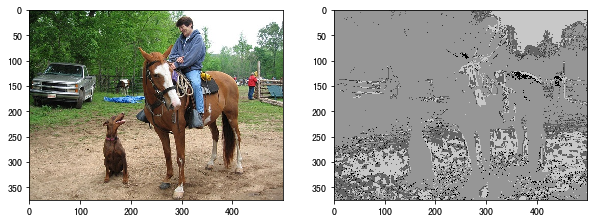

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# K-means step1
def k_means_step1(img, Class=5):
	#  get shape
	H, W, C = img.shape

	# initiate random seed
	np.random.seed(0)

	# reshape
	img = np.reshape(img, (H * W, -1))

	# select one index randomly
	i = np.random.choice(np.arange(H * W), Class, replace=False)
	Cs = img[i].copy()

	print(Cs)

	clss = np.zeros((H * W), dtype=int)

	# each pixel
	for i in range(H * W):
		# get distance from base pixel
		dis = np.sqrt(np.sum((Cs - img[i]) ** 2, axis=1))
		# get argmin distance
		clss[i] = np.argmin(dis)

	# show
	out = np.reshape(clss, (H, W)) * 50
	out = out.astype(np.uint8)

	return out


# read image
img = cv2.imread("Images/01/09/02.jpg")
out = k_means_step1(img.astype(np.float32))
plt.figure(figsize=(10,5), facecolor='w')
plt.subplot(1, 2, 1) 
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2) 
plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))

## 2.2.减色处理
- 计算各个索引下像素的颜色的平均值，这个平均值成为新的类别；
- 如果原来的类别和新的类别完全一样的话，算法结束。如果不一样的话，重复步骤2和步骤3；
- 将原图像的各个像素分配到色彩距离最小的那个类别中去。

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

def k_means(img, Class=5):
    # get shape
    H, W, C = img.shape

    # initiate random seed
    np.random.seed(0)

    # reshape image
    img = np.reshape(img, (H * W, -1))

    # get index randomly
    i = np.random.choice(np.arange(H * W), Class, replace=False)
    Cs = img[i].copy()

    while True:
        # prepare pixel class label
        clss = np.zeros((H * W), dtype=int)
        
        # each pixel
        for i in range(H * W):
            # get distance from index pixel
            dis = np.sqrt(np.sum((Cs - img[i])**2, axis=1))
            # get argmin distance
            clss[i] = np.argmin(dis)

        # selected pixel values
        Cs_tmp = np.zeros((Class, 3))
        
        # each class label
        for i in range(Class):
            Cs_tmp[i] = np.mean(img[clss == i], axis=0)

        # if not any change
        if (Cs == Cs_tmp).all():
            break
        else:
            Cs = Cs_tmp.copy()

    # prepare out image
    out = np.zeros((H * W, 3), dtype=np.float32)

    # assign selected pixel values  
    for i in range(Class):
        out[clss == i] = Cs[i]

    print(Cs)
        
    out = np.clip(out, 0, 255)

    # reshape out image
    out = np.reshape(out, (H, W, 3))
    out = out.astype(np.uint8)

    return out

# read image

img = cv2.imread("Images/01/09/02.jpg")
out = k_means(img.astype(np.float32))
plt.figure(figsize=(10,5), facecolor='w')
plt.subplot(1, 2, 1) 
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2) 
plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))

KeyboardInterrupt: 